# Notebook for testing procedure

## Load packages and setup CUDA device

In [1]:
%matplotlib inline

import time
import dataset as dc
import sys
import os
import matplotlib.pyplot as plt
import torch.optim as optim
import gstools as gs

from gstools.random import MasterRNG
from torchsummary import summary
from scipy.ndimage import gaussian_filter
from tqdm.notebook import tqdm_notebook as tqdm
from torch.utils.data import TensorDataset, DataLoader 
from sklearn.metrics import accuracy_score, classification_report

#sys.path.append("../../CNN_model/")
from fwi import *
from model import *
from train import *
from utils import *
from dataset import *
from parameter import *
from utilsSeed import *

/home/wgc/anaconda3/envs/deepwaveold_env/lib/python3.7/site-packages/torchaudio/backend/utils.py:54: UserWarning: "sox" backend is being deprecated. The default backend will be changed to "sox_io" backend in 0.8.0 and "sox" backend will be removed in 0.9.0. Please migrate to "sox_io" backend. Please refer to https://github.com/pytorch/audio/issues/903 for the detail.
  '"sox" backend is being deprecated. '


In [2]:
######  Check CUP or GPU  ######
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
cuda_available = torch.cuda.is_available()
device = torch.device("cuda" if cuda_available else "cpu")
print(device)

cuda


## Load configurations

In [3]:
from hydra import initialize, compose

with initialize(version_base=None, config_path="./"):
    cfg = compose("config_grf_50_particles")

In [4]:
# set grid
x = torch.arange(cfg.params.ox, cfg.params.nx)
z = torch.arange(cfg.params.oz, cfg.params.nz)
t = torch.arange(cfg.params.ot, cfg.params.nt) * cfg.params.dt

Z, X = torch.meshgrid(z, x)

# set sources
x_s = torch.zeros(
    cfg.params.ns, cfg.params.num_sources_per_shot, cfg.params.num_dims
)
x_s[:, 0, 1] = torch.arange(cfg.params.ns).float() * cfg.params.ds
x_s[:, 0, 0] = cfg.params.sz

# set receivers
x_r = torch.zeros(cfg.params.ns, cfg.params.nr, cfg.params.num_dims)
x_r[0, :, 1] = torch.arange(cfg.params.nr).float() * cfg.params.dr
x_r[:, :, 1] = x_r[0, :, 1].repeat(cfg.params.ns, 1)
x_r[:, :, 0] = cfg.params.rz

In [5]:
x_s.shape

torch.Size([15, 1, 2])

## Create source wavelet

Ricker wavelet: [nt, num_shots, num_sources_per_shot]

In [6]:
# ricker wavelet
source_wavelet = generate_ricker_source_wavelet(cfg)

In [7]:
source_wavelet.shape

torch.Size([4000, 15, 1])

## Load velocity models

True model min: 1.48, max: 5.69


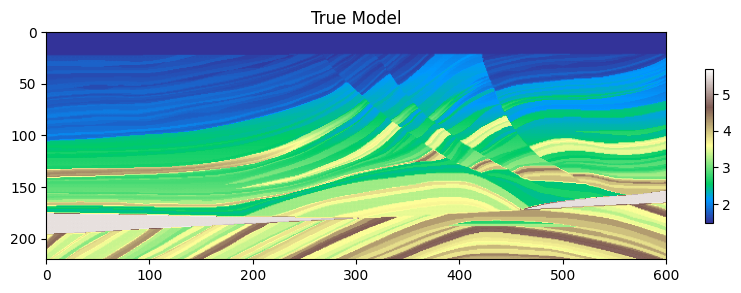

In [8]:
# Load the true model
model_true = load_velocity_model(cfg, device=device)
m_vmin, m_vmax = (
    model_true.detach().cpu().numpy().min(),
    model_true.detach().cpu().numpy().max(),
)
print(f"True model min: {m_vmin:.2f}, max: {m_vmax:.2f}")

# create mask for water layer
msk = mask(model_true, water_velocity=1.5, device=device)

plt.figure(figsize=(10, 4))
# plot true model
plt.imshow(model_true.detach().cpu().numpy(), 
           vmin=m_vmin, 
           vmax=m_vmax, 
           cmap='terrain',
           extent=[x[0], 
                   x[-1], 
                   z[-1], 
                   z[0]]
                   )
plt.title('True Model')
plt.colorbar(shrink=0.5)

Loaded model from ./data/deterministic_fwi_result.npy


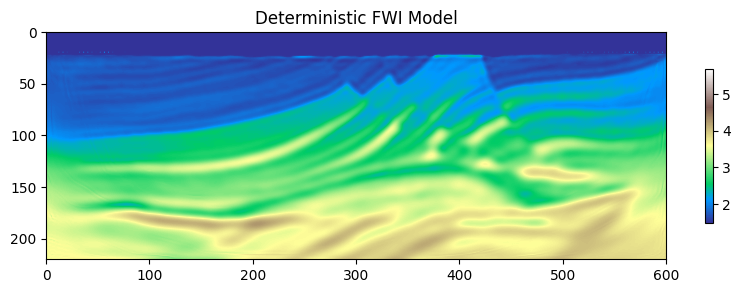

In [9]:
# load the deterministic optimization results
model_fwi = np.load(f"{cfg.paths.fwi_model_path}")
print(f"Loaded model from {cfg.paths.fwi_model_path}")

plt.figure(figsize=(10, 4))
# plot the deterministic optimization results
plt.imshow(model_fwi, 
           vmin=m_vmin, 
           vmax=m_vmax, 
           cmap='terrain',
           extent=[x[0], 
                   x[-1], 
                   z[-1], 
                   z[0]]
                   )
plt.title('Deterministic FWI Model')
plt.colorbar(shrink=0.5)

### load CNN model 

In [10]:
# define model
input_channel  = 1
output_channel = 1
n_condition    = num_particles
n_feat   = 512
n_cfeat  = num_particles
model = CONTEXT_UNET(in_channels=input_channel, out_channels=output_channel, n_feat=n_feat, n_cfeat=n_cfeat, feature=[8, 16, 32, 64, 128]).to(device)

model_file  = './Pretrained-network/Dip_pretrain_small_model_iter2000.pth.tar'
state = torch.load(model_file)
model.load_state_dict(state['state_dict'])
cnnmodel = model.to(device)

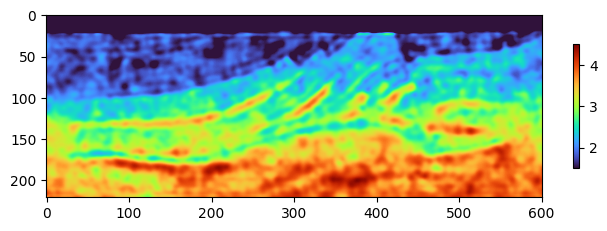

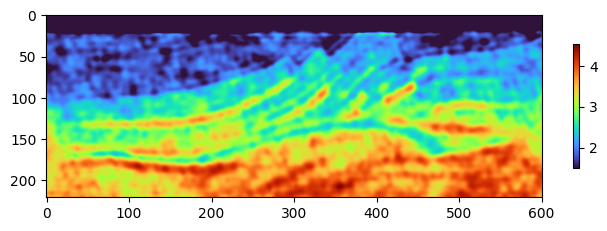

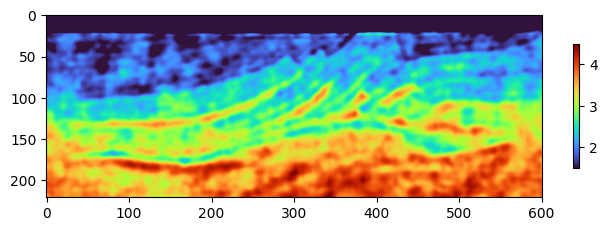

In [11]:
data1 = torch.randn([1, 1, nz, nx]).to(device)
data2 = torch.eye(cfg.params.num_particles).to(device)
output0=cnnmodel(data1,data2[0])
output1=cnnmodel(data1,data2[1])
output2=cnnmodel(data1,data2[2])

# model1 plot
plt.figure(figsize=(8,4))
plt.imshow(output0.detach().cpu().numpy().reshape(nz,nx),
            cmap="turbo",
            )
plt.colorbar(shrink=0.4)

# model2 plot
plt.figure(figsize=(8,4))
plt.imshow(output1.detach().cpu().numpy().reshape(nz,nx),
            cmap="turbo",
            )
plt.colorbar(shrink=0.4)

# model1 plot
plt.figure(figsize=(8,4))
plt.imshow(output2.detach().cpu().numpy().reshape(nz,nx),
            cmap="turbo",
            )
plt.colorbar(shrink=0.4)

In [12]:
data2  = torch.eye(num_particles).to(device)
model_output =[]

for i in range (num_particles):
    output=cnnmodel(data1,data2[i])
    model_output.append(output.detach().clone().cpu().numpy()) 

total = np.array(model_output).reshape(num_particles,-1)
total_output = torch.tensor(total)

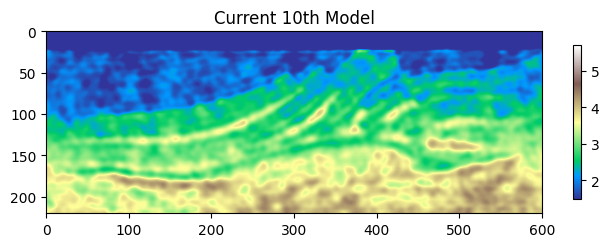

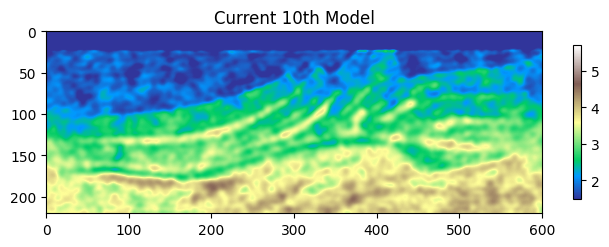

In [13]:
plt.figure(figsize=(8, 4))
gr1 = total_output[10,:].reshape(cfg.params.nz, cfg.params.nx)
gr2 = total_output[40,:].reshape(cfg.params.nz, cfg.params.nx)
# g_min, g_max = np.percentile(
#     updates_std[-1].reshape(cfg.params.nz, cfg.params.nx), [2, 98]
# )
g_min = m_vmin
g_max = m_vmax

plt.imshow(gr1, 
            cmap="terrain", 
            vmin=g_min, 
            vmax=g_max,
            extent=[x[0], 
                    x[-1], 
                    z[-1], 
                    z[0]]
            )
plt.title("Current 10th Model")
plt.colorbar(shrink=0.5)
plt.show()

plt.figure(figsize=(8, 4))
plt.imshow(gr2, 
            cmap="terrain", 
            vmin=g_min, 
            vmax=g_max,
            extent=[x[0], 
                    x[-1], 
                    z[-1], 
                    z[0]]
            )
plt.title("Current 10th Model")
plt.colorbar(shrink=0.5)
plt.show()

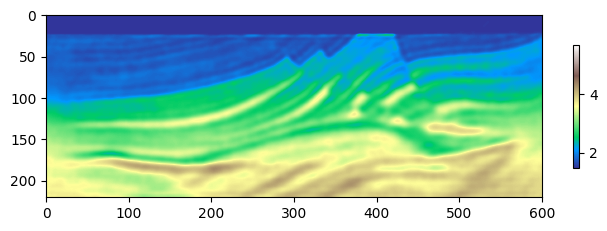

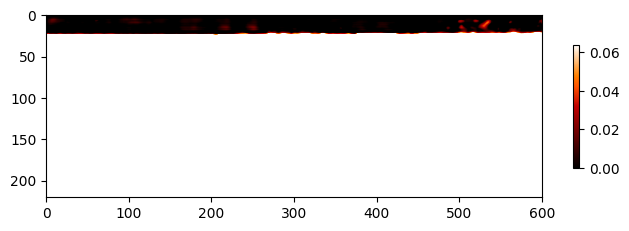

In [14]:
mean_output = total_output.view(cfg.params.num_particles,-1).detach().clone().cpu().numpy().mean(0)
std_output  = total_output.view(cfg.params.num_particles,-1).detach().clone().cpu().numpy().std(0)

plt.figure(figsize=(8,4))
plt.imshow(mean_output.reshape(nz,nx),
           vmin=m_vmin, 
           vmax=m_vmax, 
           cmap='terrain',
            interpolation="bilinear",
            extent=[x[0], 
                   x[-1], 
                   z[-1], 
                   z[0]])
plt.colorbar(shrink=0.4)

plt.figure(figsize=(8,4))
plt.imshow(std_output.reshape(nz,nx),
        cmap="gist_heat", 
        vmin=0,
        vmax=0.064,
        extent=[x[0], 
                x[-1], 
                z[-1], 
                z[0]]
        )
plt.colorbar(shrink=0.4)

### sorce and record

In [15]:
# generate data
data_true = generate_data(source_wavelet, cfg, x_s, x_r, model_true, device=device)

# generate noisy data
data_noisy = add_white_noise(
    data_true,
    noise_level=1e-7,
    filter=None,
)

# compute data snr
data_noisy_snr = snr(
    data_true.detach().cpu().numpy(), data_noisy.detach().cpu().numpy()
)
print(f"Noisy data SNR: {data_noisy_snr:.2f} dB")

Noisy data SNR: 11.61 dB


In [16]:
scaler = torch.max(torch.abs(data_true))*0.1
data_true /= scaler
print(scaler)

tensor(1.0201e-05, device='cuda:0')


In [17]:
data_noisy.shape

torch.Size([4000, 15, 300])

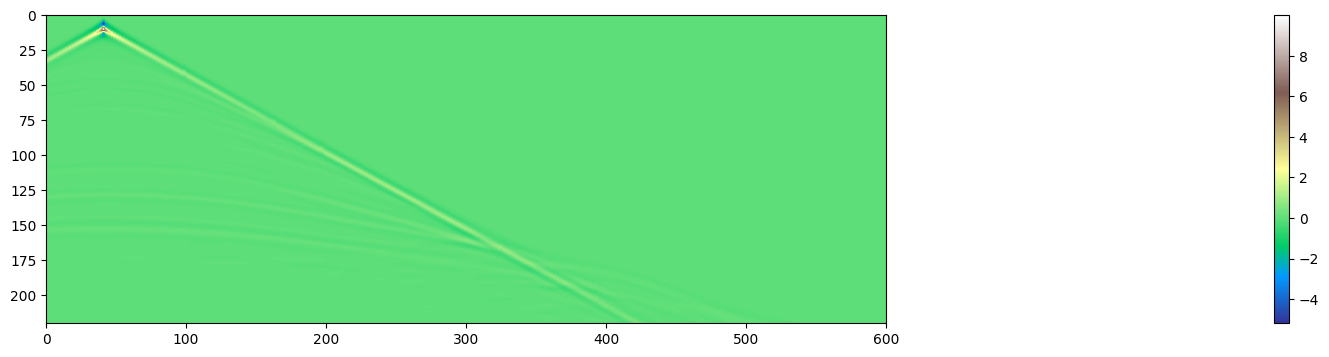

In [18]:
plt.figure(figsize=(100, 4))
plt.imshow(
    data_true[:,1,:].detach().cpu().numpy(),
    cmap="terrain",
    extent=[x[0], 
        x[-1], 
        z[-1], 
        z[0]]
)
plt.colorbar()
plt.show()

### Begin FWI

In [19]:
num_particles = cfg.params.num_particles

In [20]:
model_init = output

trans_type = 'linear' # linear, square, exp, softplus, abs
survey_pad = None
pml_width  = [0,10,10,10]   # pml padding width for boundary (0 for free surface and 10 for absorbing boundary)

In [21]:
# simulation parameters
lr = 1e-4
weight_decays =  0.001
log_prior_scale = cfg.params.log_prior_scale

# functionals
log_likelihood = torch.nn.MSELoss()
log_prior = None
optimizer = torch.optim.Adam(
    [{"params": cnnmodel.parameters(), "lr": lr, "weight_decays": weight_decays}]
)
scheduler1 = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer, cfg.params.num_iterations + 1, 0
)
grad_func = lambda x: compute_gradient(
    x,
    x_s,
    x_r,
    data_noisy,
    source_wavelet,
    cfg,
    log_likelihood,
    log_prior,
    log_prior_scale,
    data_max_normalization,
    device,
)
filter_func = lambda x: gaussian_2d_filter(x, sigmax=2.0, sigmay=2.5)


In [22]:
source_wavelet.shape

torch.Size([4000, 15, 1])

In [23]:
data1 = torch.randn([1, 1, nz, nx]).to(device)
data1_saved = data1

In [24]:
#Learning Schedule
def lr_lambda(epoch):
    return 1/10

In [25]:
cfg.params.batch_size

30

In [26]:
grad_func = lambda x: compute_gradient(
    x,
    x_s,
    x_r,
    data_noisy,
    source_wavelet,
    cfg,
    log_likelihood,
    log_prior,
    log_prior_scale,
    data_max_normalization,
    device,
)

In [27]:
cfg.params.num_iterations = 100
cfg.params.batch_size=1

Starting inversion with 50 particles


  0%|          | 0/100 [00:00<?, ?it/s]

Training set: Average loss 0.024874284234829246


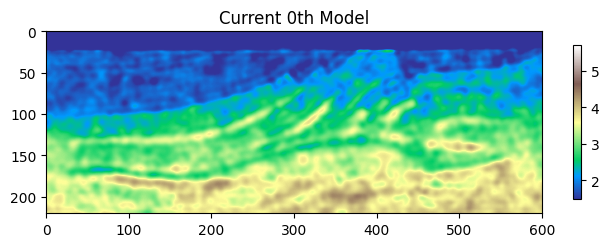

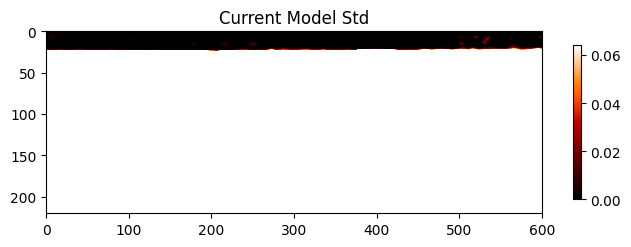

<Figure size 800x400 with 0 Axes>

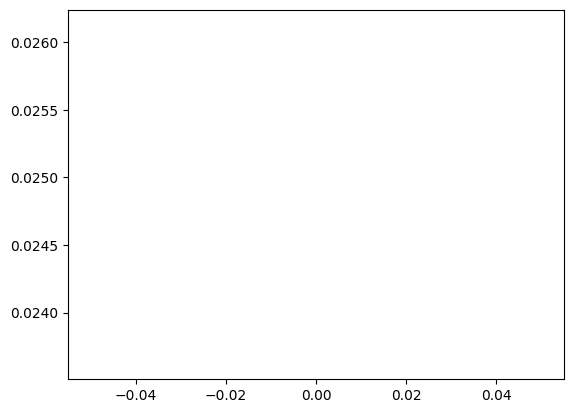

Training set: Average loss 0.018833386473124845
Training set: Average loss 0.016493588539306075
Training set: Average loss 0.014481975466478616
Training set: Average loss 0.012935250062146224
Training set: Average loss 0.01171592733298894


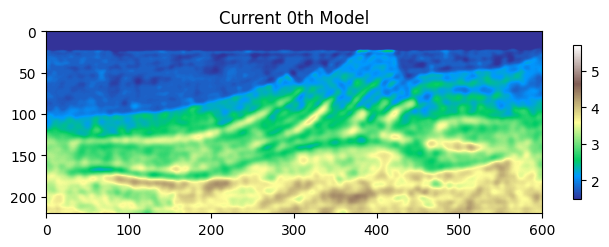

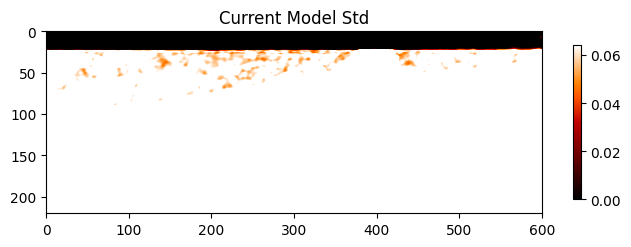

<Figure size 800x400 with 0 Axes>

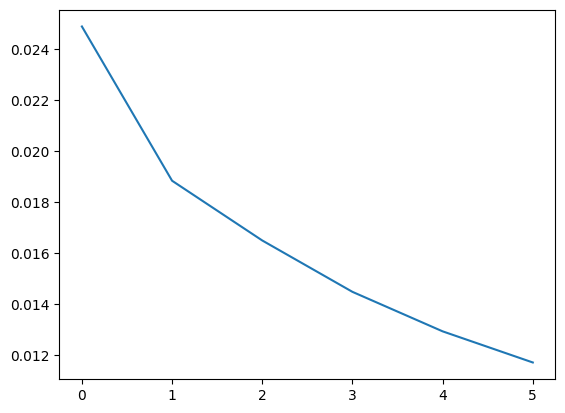

Training set: Average loss 0.010626486186520196
Training set: Average loss 0.0097275159007404
Training set: Average loss 0.009021020520012826
Training set: Average loss 0.008399583206628449
Training set: Average loss 0.007819650713354349


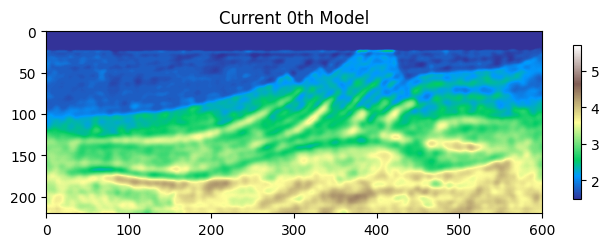

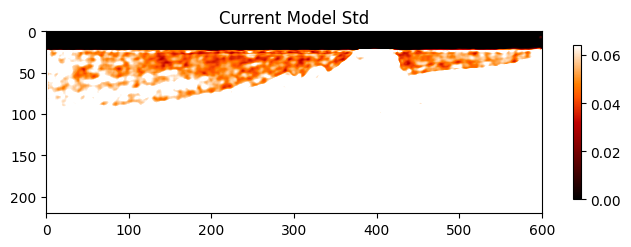

<Figure size 800x400 with 0 Axes>

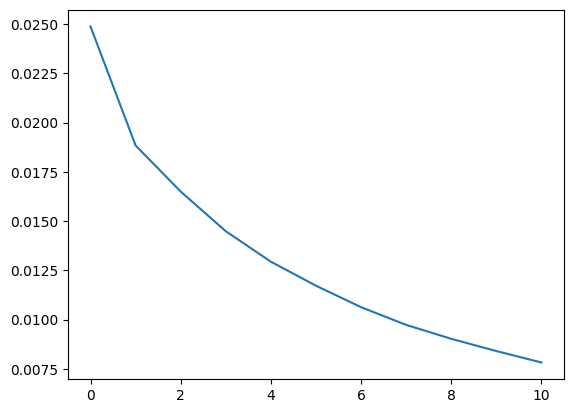

Training set: Average loss 0.007347515054862015
Training set: Average loss 0.006938760413904674
Training set: Average loss 0.0065516910870792346
Training set: Average loss 0.006213433967204764
Training set: Average loss 0.0059213524905499075


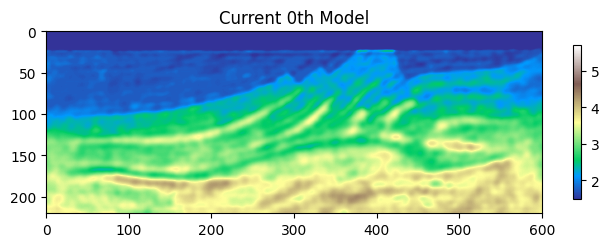

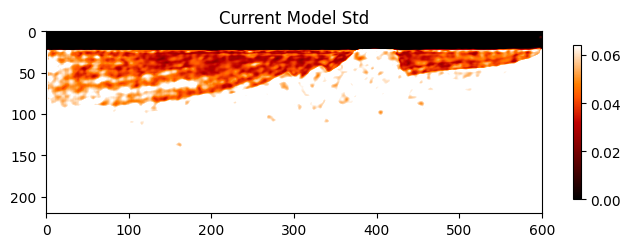

<Figure size 800x400 with 0 Axes>

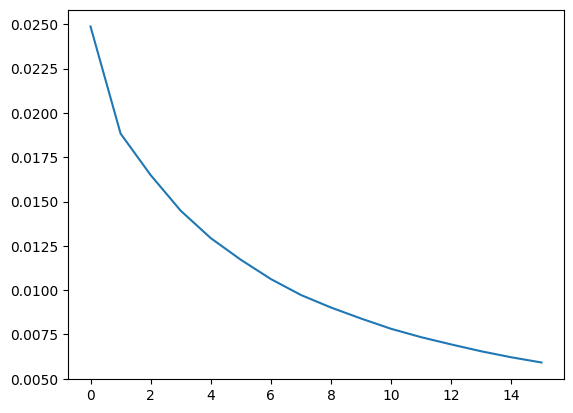

Training set: Average loss 0.005650519015325699
Training set: Average loss 0.005395254697068594
Training set: Average loss 0.005173304649360944
Training set: Average loss 0.0049634998280089345
Training set: Average loss 0.004757986214244738


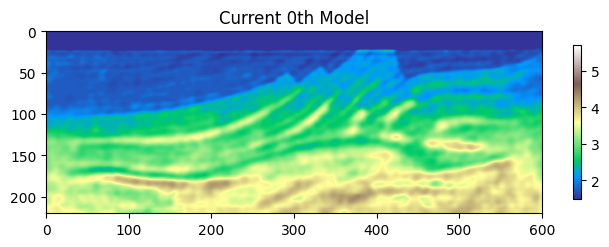

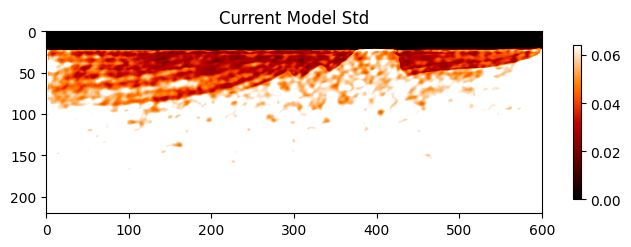

<Figure size 800x400 with 0 Axes>

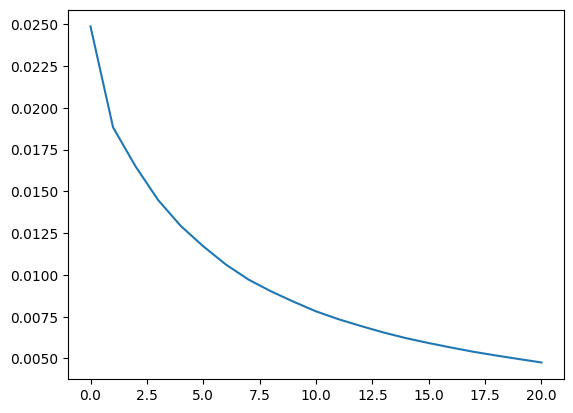

Training set: Average loss 0.004583820163679775
Training set: Average loss 0.00441635925322771
Training set: Average loss 0.004254013338359073
Training set: Average loss 0.004105136123835109
Training set: Average loss 0.0039700539273326285


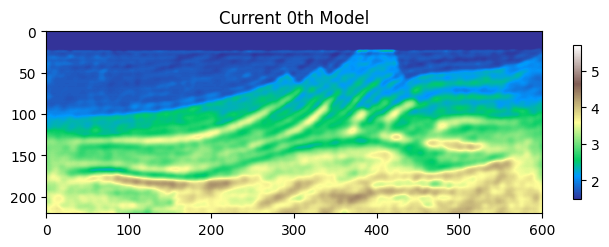

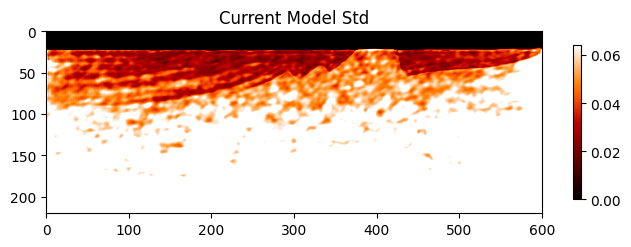

<Figure size 800x400 with 0 Axes>

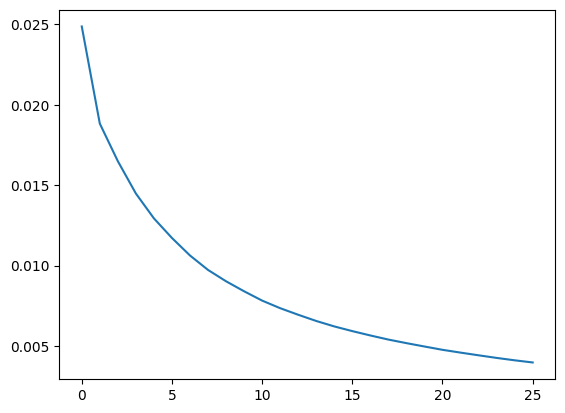

Training set: Average loss 0.003834504999103956
Training set: Average loss 0.003701983954233583
Training set: Average loss 0.0035943398531526325
Training set: Average loss 0.003477517963619903
Training set: Average loss 0.0033608169172657655


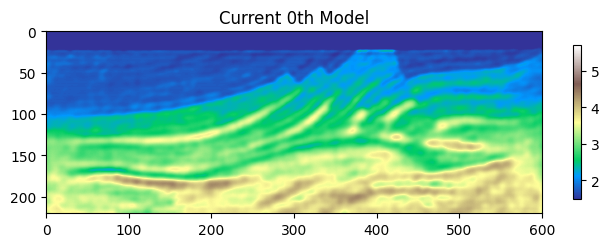

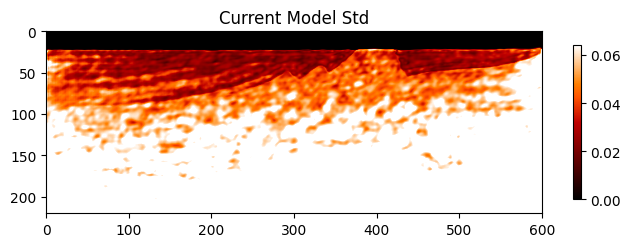

<Figure size 800x400 with 0 Axes>

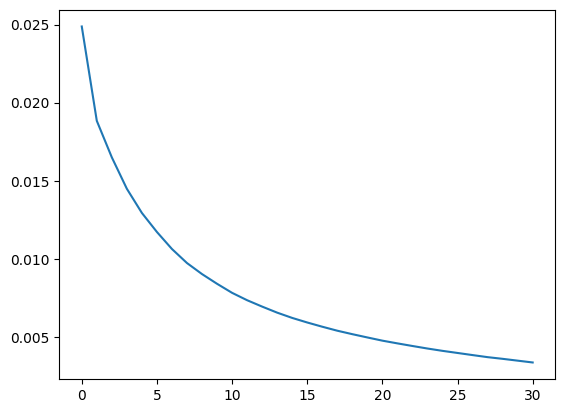

Training set: Average loss 0.0032588854027562775
Training set: Average loss 0.00315859170834301
Training set: Average loss 0.0030543237875099295
Training set: Average loss 0.0029553019744344056
Training set: Average loss 0.002874318341782782


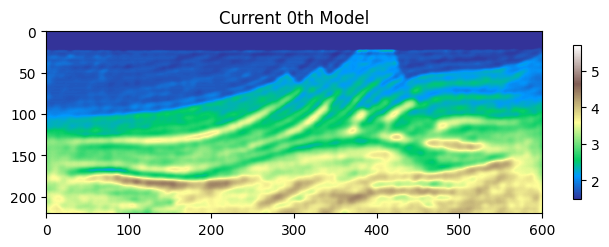

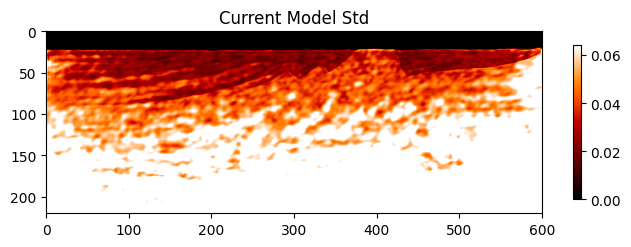

<Figure size 800x400 with 0 Axes>

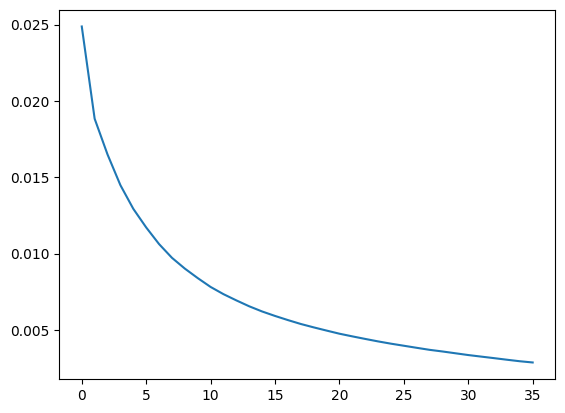

Training set: Average loss 0.002782511141267605
Training set: Average loss 0.0026894637240911833
Training set: Average loss 0.002612320492917206
Training set: Average loss 0.002532365306833526
Training set: Average loss 0.002448117229505442


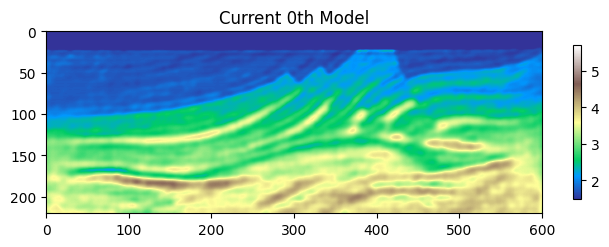

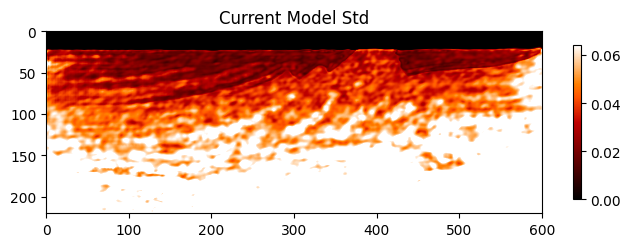

<Figure size 800x400 with 0 Axes>

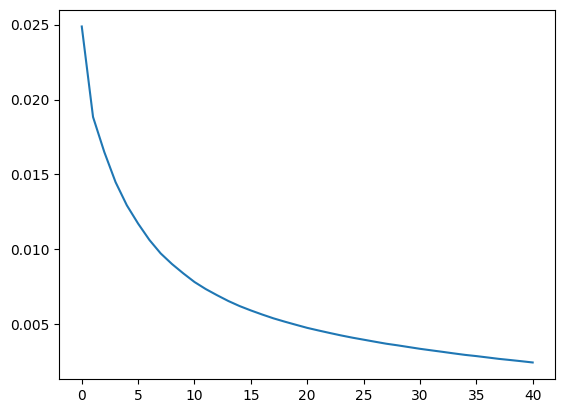

Training set: Average loss 0.0023706759253400377
Training set: Average loss 0.002303745359677123
Training set: Average loss 0.0022272247010550928
Training set: Average loss 0.002150357946375152
Training set: Average loss 0.00208571263749036


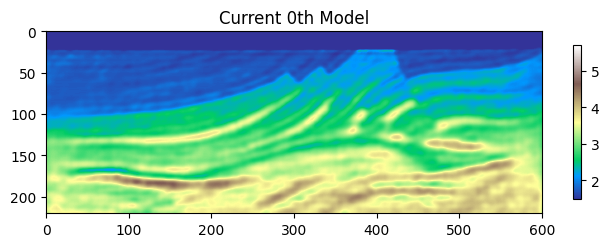

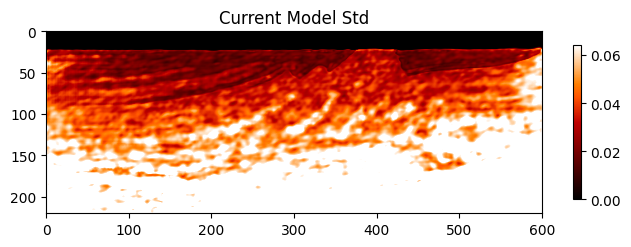

<Figure size 800x400 with 0 Axes>

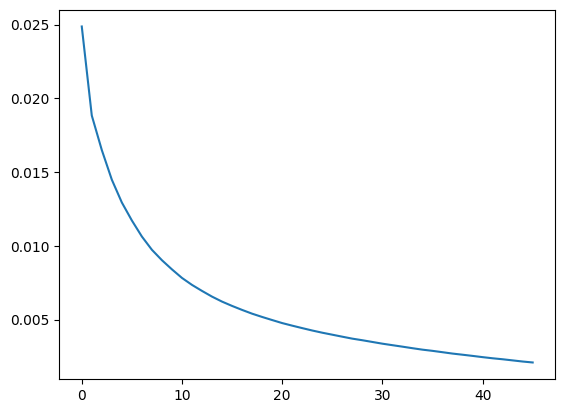

Training set: Average loss 0.002017647975881118
Training set: Average loss 0.0019477469420235139
Training set: Average loss 0.00188492493252852
Training set: Average loss 0.0018290986833744683
Training set: Average loss 0.001766539561067475


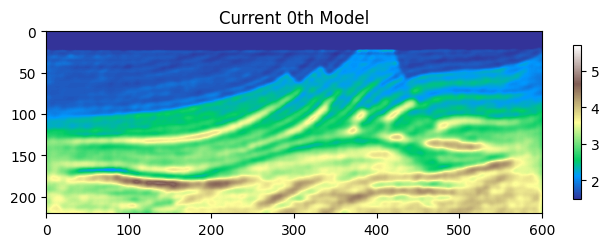

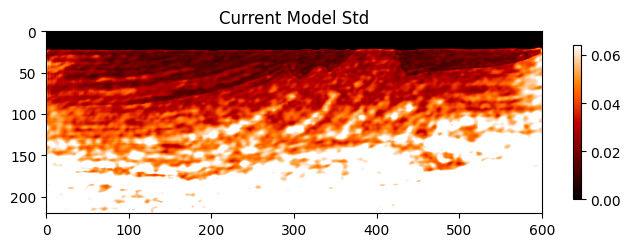

<Figure size 800x400 with 0 Axes>

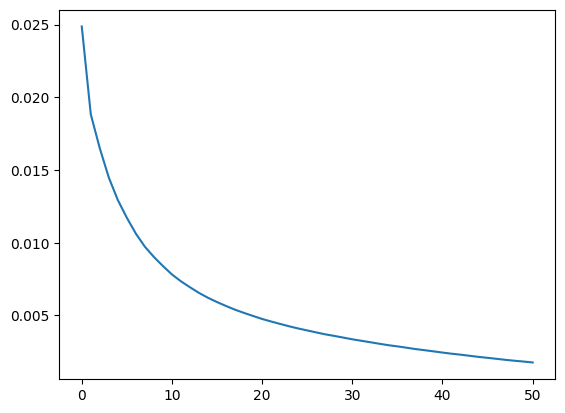

Training set: Average loss 0.0017060740453598555
Training set: Average loss 0.0016559120528108907
Training set: Average loss 0.0016014095091668424
Training set: Average loss 0.0015464169028564356
Training set: Average loss 0.0014973703735449817


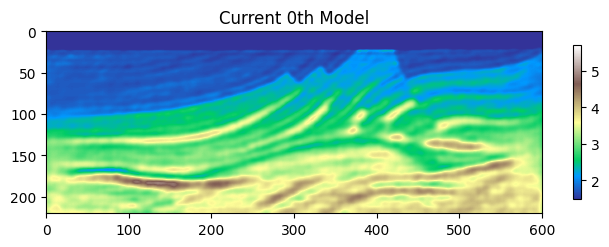

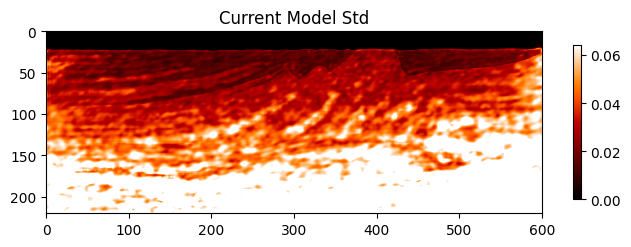

<Figure size 800x400 with 0 Axes>

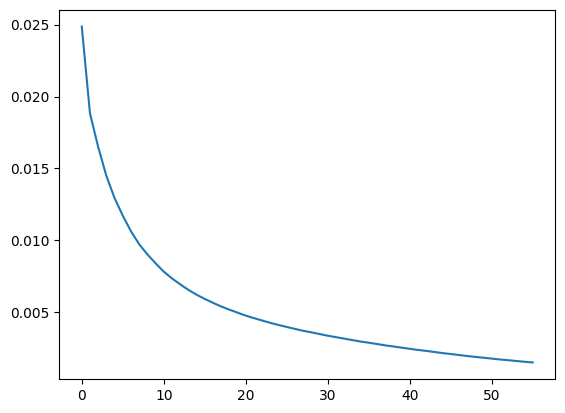

Training set: Average loss 0.0014527243556221947
Training set: Average loss 0.0014039088280696887
Training set: Average loss 0.0013571266358485446
Training set: Average loss 0.0013178671451169067
Training set: Average loss 0.0012748443191230763


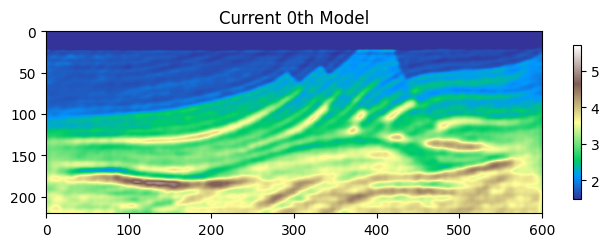

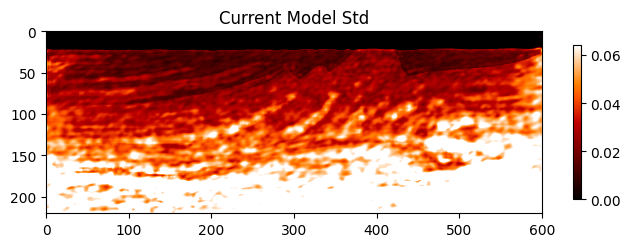

<Figure size 800x400 with 0 Axes>

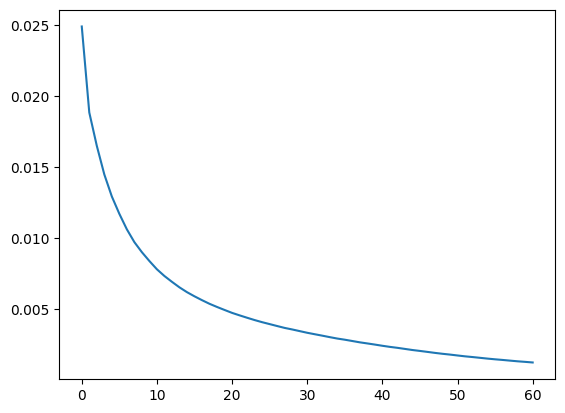

Training set: Average loss 0.0012328314158366993
Training set: Average loss 0.0011952377401757985
Training set: Average loss 0.0011601400627841941
Training set: Average loss 0.001122767531342106
Training set: Average loss 0.0010866449202148942


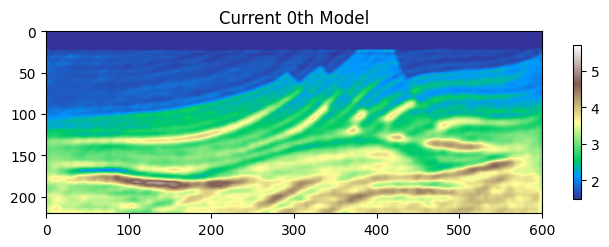

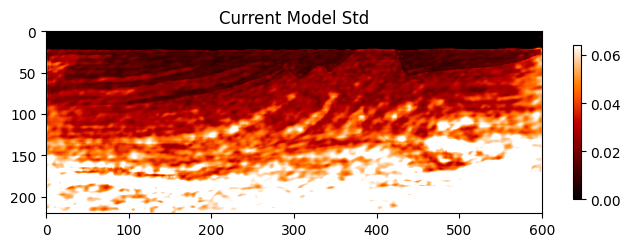

<Figure size 800x400 with 0 Axes>

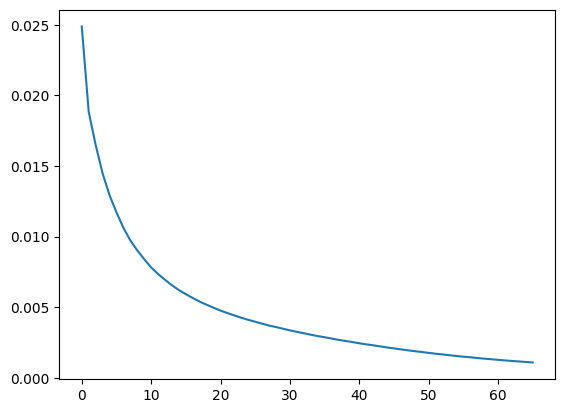

Training set: Average loss 0.0010570424299658043
Training set: Average loss 0.0010236446149792756
Training set: Average loss 0.0009919342822104227
Training set: Average loss 0.0009638692445150809
Training set: Average loss 0.0009367048748390516


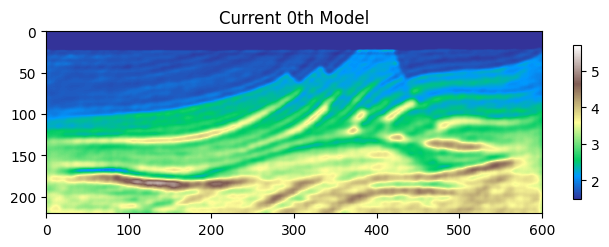

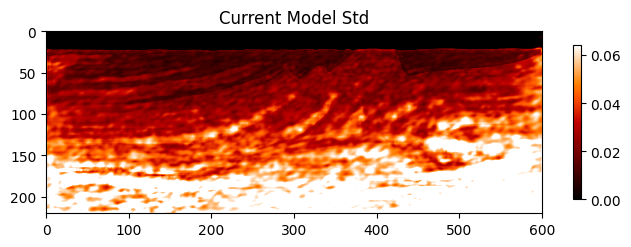

<Figure size 800x400 with 0 Axes>

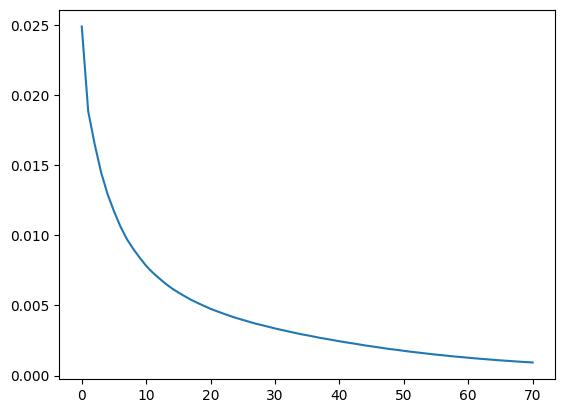

Training set: Average loss 0.0009085888668050756
Training set: Average loss 0.0008811809566395823
Training set: Average loss 0.0008589569443574874
Training set: Average loss 0.0008330922517779982
Training set: Average loss 0.0008093823625677033


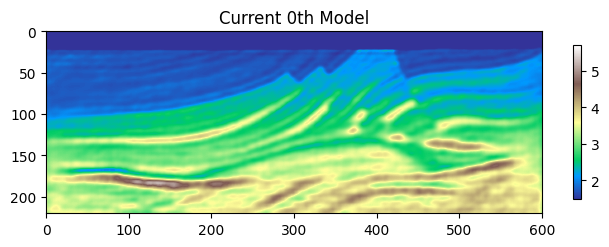

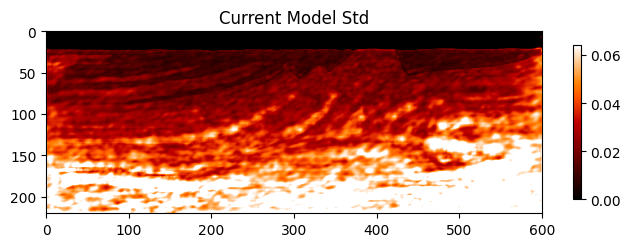

<Figure size 800x400 with 0 Axes>

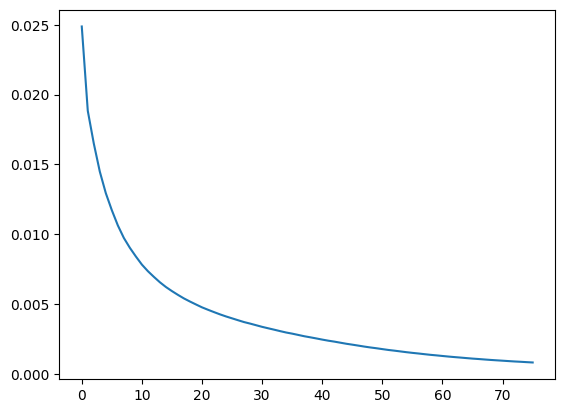

Training set: Average loss 0.0007886405732278945
Training set: Average loss 0.0007670936809154227
Training set: Average loss 0.00074545516341459
Training set: Average loss 0.0007241680908191484
Training set: Average loss 0.0007074379911500728


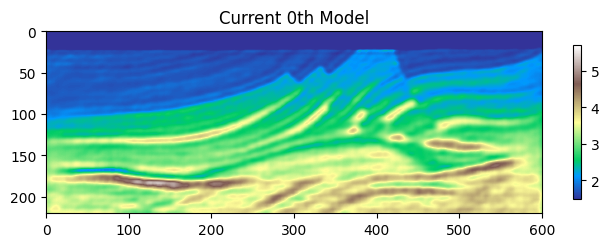

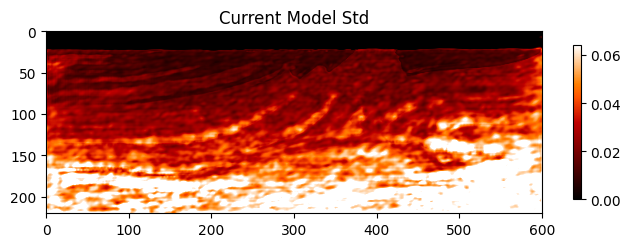

<Figure size 800x400 with 0 Axes>

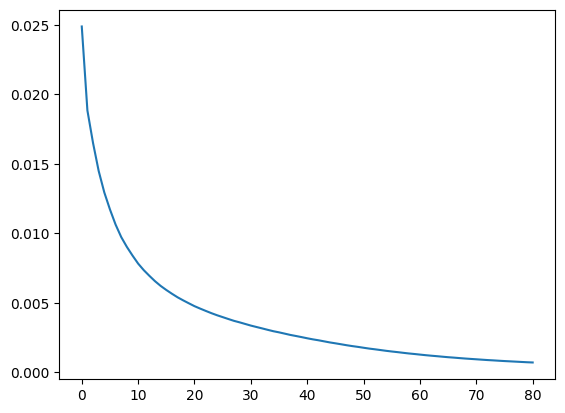

Training set: Average loss 0.0006872391962679103
Training set: Average loss 0.0006691380749907693
Training set: Average loss 0.0006539989967131988
Training set: Average loss 0.0006371368395048193
Training set: Average loss 0.0006206640211166814


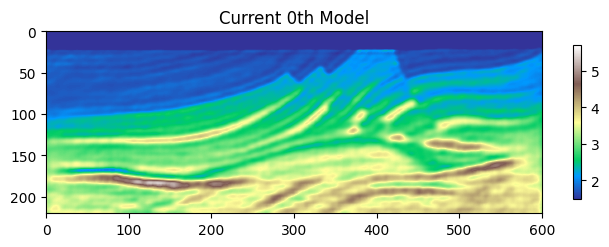

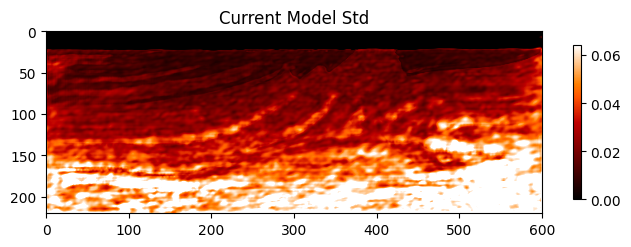

<Figure size 800x400 with 0 Axes>

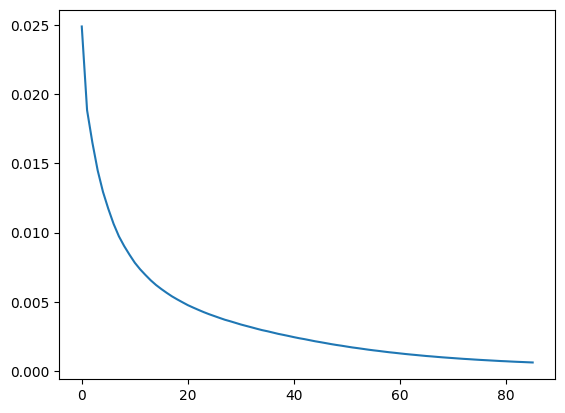

Training set: Average loss 0.000604530968448671
Training set: Average loss 0.0005924251143369474
Training set: Average loss 0.0005771389942674432
Training set: Average loss 0.0005636493158090161
Training set: Average loss 0.0005529962014043121


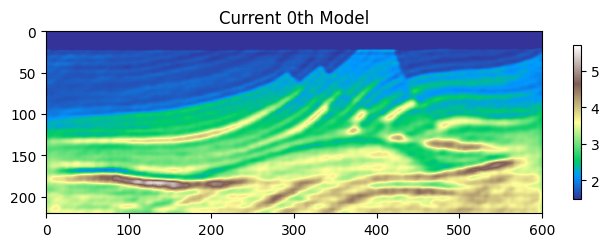

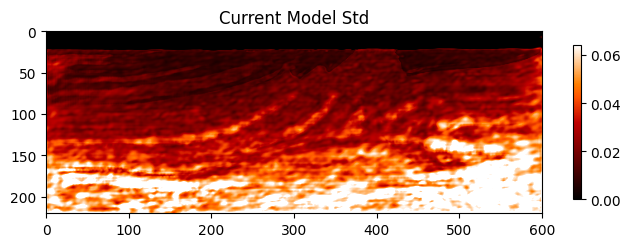

<Figure size 800x400 with 0 Axes>

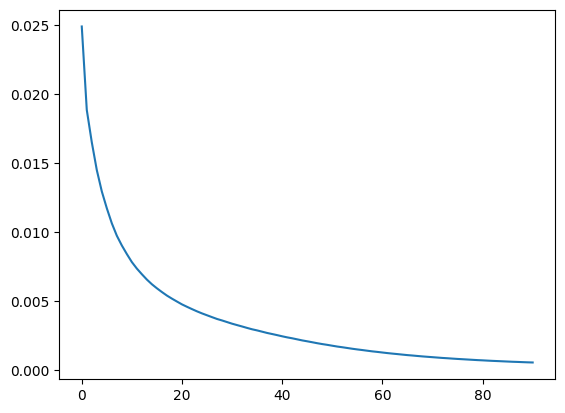

Training set: Average loss 0.0005400755687151104
Training set: Average loss 0.0005277672015654389
Training set: Average loss 0.0005158419639337808
Training set: Average loss 0.0005071566154947505
Training set: Average loss 0.0004958800324675394


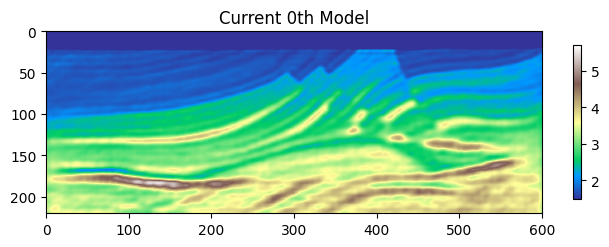

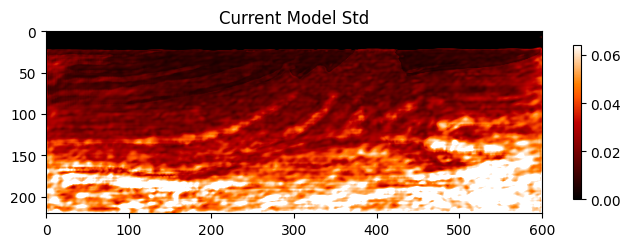

<Figure size 800x400 with 0 Axes>

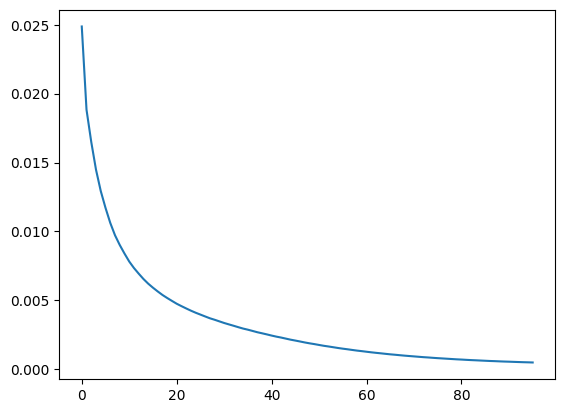

Training set: Average loss 0.00048572385880106593
Training set: Average loss 0.0004785120045562508
Training set: Average loss 0.0004688105204695603
Training set: Average loss 0.00045951988104206973
Runtime: 226.0935129205386 minutes


In [28]:
# iterative inversion loop
epoch_loss = []
updates = []
updates_mean = []
updates_std = []
gradients = []
loss_cnn_list   = []


# start simulation
print(f"Starting inversion with {cfg.params.num_particles} particles")

#scheduler = torch.optim.lr_scheduler.MultiplicativeLR(optimizer, lr_lambda=lr_lambda)
n_epochs = tqdm(range(cfg.params.num_iterations))
t_start = time.time()
for iteration in n_epochs:

    epoch_loss = 0
    loop_batch = np.arange(0, cfg.params.ns, 1)

    for ishot in (loop_batch):
        # generate model
        random_permutation = torch.arange(0,num_particles)
        data2  = torch.eye(num_particles)[:, random_permutation].to(device)

        for imodel in range (0, cfg.params.num_particles, 1):     

            cnnmodel.train()
            optimizer.zero_grad()
            loss_cnn = 0.0
            for p in cnnmodel.parameters():
                p.requires_grad_(True) 

            data1_input = data1_saved + data1_saved.normal_() * 1./10
            random_permutation = torch.arange(0,num_particles)

            model=cnnmodel(data1_input, data2[imodel]).view(nz,nx) 
            #model.clamp_(m_vmin, m_vmax)

            batch_data_true = data_true[:, ishot:ishot+cfg.params.batch_size].detach().to(device)
            batch_x_s = x_s[ishot:ishot+cfg.params.batch_size,:,:].to(device)
            batch_x_r = x_r[ishot:ishot+cfg.params.batch_size,:,:].to(device)
            batch_src_wvl = source_wavelet[
                :,
                ishot:ishot+cfg.params.batch_size,
            ].to(device)

            # forward modeling
            prop = dw.scalar.Propagator({"vp": model.to(device)}, cfg.params.dx)
            
            batch_data_pred = prop(batch_src_wvl, batch_x_s, batch_x_r, cfg.params.dt).to(device)
            batch_data_pred = batch_data_pred / scaler    
            
            #loss_cnn += Wasserstein1(batch_data_pred, batch_data_true, trans_type, theta=1.1) 
            loss_cnn  = log_likelihood(batch_data_pred, batch_data_true)
            epoch_loss += loss_cnn.item()

            # update the cnnmodel
            loss_cnn.backward()

            optimizer.step()
            scheduler1.step()

    print('Training set: Average loss',(epoch_loss / cfg.params.num_particles))
    loss_cnn_list.append(epoch_loss/ cfg.params.num_particles) 

    with torch.no_grad():
        model_output_save =[]
        for i in range (cfg.params.num_particles):
            output=cnnmodel(data1,data2[i])
            model_output_save.append(output.detach().clone().cpu().numpy()) 
        total = np.array(model_output_save).reshape(cfg.params.num_particles,-1)
        model_iter = torch.tensor(total)
        #model_iter.clamp_(m_vmin, m_vmax)

    if torch.isnan(model_iter).any():
        print("NaN detected from model_iter")

    # save the model updates and gradients for each iteration
    updates.append(model_iter.detach().clone().cpu().numpy())
    updates_mean.append(model_iter.detach().clone().cpu().numpy().mean(0))
    updates_std.append(model_iter.detach().clone().cpu().numpy().std(0))

    # plot the model updates and gradients
    if iteration % 5 == 0:
        plt.figure(figsize=(8, 4))
        plt.imshow(
            model_iter[0,:].detach().cpu().numpy().reshape(cfg.params.nz, cfg.params.nx),
            vmin=m_vmin,
            vmax=m_vmax,
            cmap="terrain",
            interpolation="bilinear",
            extent=[x[0], 
                    x[-1], 
                    z[-1], 
                    z[0]]
        )
        plt.title("Current 0th Model")
        plt.colorbar(shrink=0.5)
        plt.show()

        plt.figure(figsize=(8, 4))
        gr = updates_std[-1].reshape(cfg.params.nz, cfg.params.nx)
        plt.imshow(
            gr,
            vmin=0,
            vmax=0.064,
            cmap="gist_heat",
            extent=[x[0], 
                    x[-1], 
                    z[-1], 
                    z[0]]
        )
        plt.title("Current Model Std")
        plt.colorbar(shrink=0.5)
        plt.show()

        plt.figure(figsize=(8, 4))
        plt.figure()
        plt.plot(loss_cnn_list)
        plt.show()

t_end = time.time()
print("Runtime:", (t_end - t_start) / 60, "minutes")

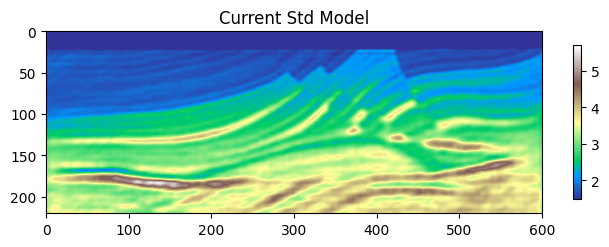

In [29]:
plt.figure(figsize=(8, 4))
gr = updates[-1][0,:].reshape(cfg.params.nz, cfg.params.nx)
# g_min, g_max = np.percentile(
#     updates_std[-1].reshape(cfg.params.nz, cfg.params.nx), [2, 98]
# )
g_min = m_vmin
g_max = m_vmax

plt.imshow(gr, 
            cmap="terrain", 
            vmin=g_min, 
            vmax=g_max,
            extent=[x[0], 
                    x[-1], 
                    z[-1], 
                    z[0]]
            )
plt.title("Current Std Model")
plt.colorbar(shrink=0.5)
plt.show()

In [30]:
conditional_out_path = 'right_50particles_idea.npz'

# convert the updates and gradients to numpy arrays
updates = np.array(updates)
updates_mean = np.array(updates_mean)
updates_std = np.array(updates_std)
gradients = np.array(gradients)
epoch_loss = np.array(epoch_loss)

np.savez(
    f"{conditional_out_path}",
    updates=updates,
    updates_mean=updates_mean,
    updates_std=updates_std,
    gradients=gradients,
    epoch_loss=epoch_loss,
)
print(f"Saved model to {conditional_out_path}")

Saved model to right_50particles_idea.npz


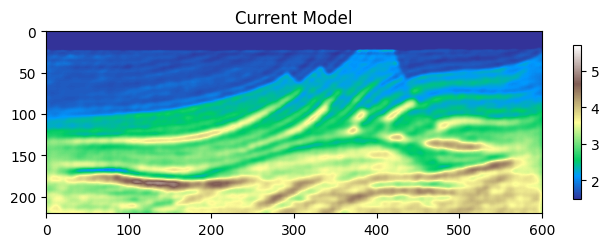

In [31]:
plt.figure(figsize=(8, 4))
gr = updates[60][0,:].reshape(cfg.params.nz, cfg.params.nx)
# g_min, g_max = np.percentile(
#     updates_std[-1].reshape(cfg.params.nz, cfg.params.nx), [2, 98]
# )
g_min = m_vmin
g_max = m_vmax

plt.imshow(gr, 
            cmap="terrain", 
            vmin=g_min, 
            vmax=g_max,
            extent=[x[0], 
                    x[-1], 
                    z[-1], 
                    z[0]]
            )
plt.title("Current Model")
plt.colorbar(shrink=0.5)
plt.show()

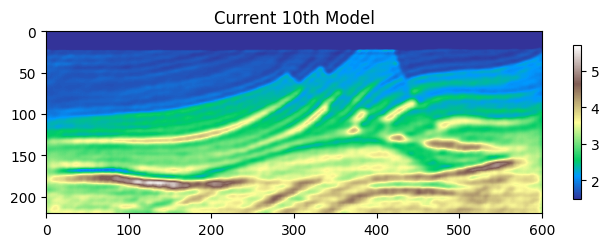

In [32]:
plt.figure(figsize=(8, 4))
gr = updates[-1][0,:].reshape(cfg.params.nz, cfg.params.nx)
# g_min, g_max = np.percentile(
#     updates_std[-1].reshape(cfg.params.nz, cfg.params.nx), [2, 98]
# )
g_min = m_vmin
g_max = m_vmax

plt.imshow(gr, 
            cmap="terrain", 
            vmin=g_min, 
            vmax=g_max,
            extent=[x[0], 
                    x[-1], 
                    z[-1], 
                    z[0]]
            )
plt.title("Current 10th Model")
plt.colorbar(shrink=0.5)
plt.show()

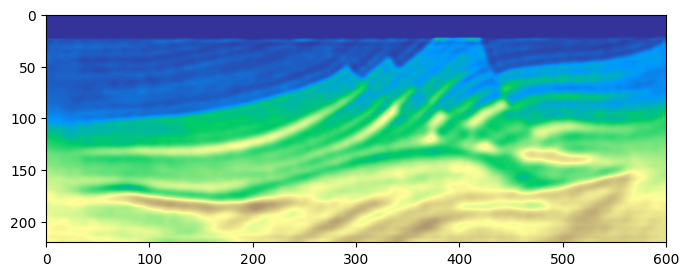

In [33]:
plt.figure(figsize=(8, 4))
gr = updates_mean[0].reshape(cfg.params.nz, cfg.params.nx)
# g_min, g_max = np.percentile(
#     updates_std[-1].reshape(cfg.params.nz, cfg.params.nx), [2, 98]
# )
g_min = m_vmin
g_max = m_vmax

plt.imshow(gr, 
            cmap="terrain", 
            vmin=g_min, 
            vmax=g_max,
            extent=[x[0], 
                    x[-1], 
                    z[-1], 
                    z[0]]
            )
#plt.title("Current mean Model")
#plt.colorbar(shrink=0.5)
plt.show()

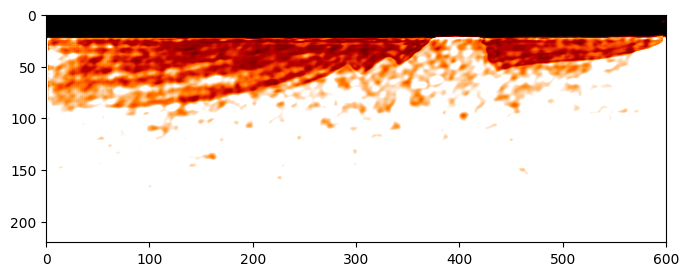

In [34]:
plt.figure(figsize=(8, 4))
gr = updates_std[20].reshape(cfg.params.nz, cfg.params.nx)
# g_min, g_max = np.percentile(
#     updates_std[-1].reshape(cfg.params.nz, cfg.params.nx), [2, 98]
# )
g_min = 0
g_max = 0.064

plt.imshow(gr, 
            cmap="gist_heat", 
            vmin=g_min, 
            vmax=g_max,
            extent=[x[0], 
                    x[-1], 
                    z[-1], 
                    z[0]]
            )
#plt.title("Current Std Model")
#plt.colorbar(shrink=0.5)
plt.show()

<Figure size 800x400 with 0 Axes>

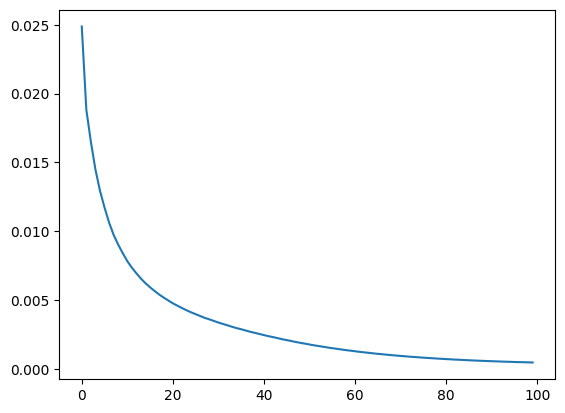

In [35]:
plt.figure(figsize=(8, 4))
plt.figure()
plt.plot(loss_cnn_list)
plt.show()